# External links and resources

We created/used the following external links and/or resources:
 - "pois_processed.csv": We processed the file with the points of interest in .json format in order to obtain the data in a tabular form.
 - "data_entities_wairsensors.csv": We created the file with the traffic sensor and the correspondent (i.e., nearest) air quality sensors, as proxy to infer the air quality in a determined region of the city.

# Introduction

Our solution focuses on forecasting traffic for the next day (at the same time) for the city of Porto. 

Regarding modeling, we used an XGBoost Classifier with weather features (current and forecast), historical intensity features, sensor position features (distance to sensor centroid).

We propose using this model for making decisions regarding traffic flow, by changing the amount of time that traffic lights are on - read more below :) 

# Development

In [6]:
# We import the needed Python libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import holidays
from geopy.distance import geodesic
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import shap
from geopy.distance import geodesic
import folium
from folium.plugins import HeatMapWithTime

# Some useful Pandas features
pd.set_option("display.max_colwidth", 500)
pt_holidays = holidays.CountryHoliday('Portugal')

# Uncomment this if you need to install some of the libraries above
# !pip install holidays
# !pip install openrouteservice
# !pip install geopy

## Load Data

This step of the script loads traffic, weather and air quality data.

We removed data in post-COVID periods (2019 and 2020) since our goal is to study how the city of Porto behaves regularly.

In [7]:
# Load preprocessed points of interest, data given by the WDL Organizers

df_pois = pd.read_csv('../data/pois_processed.csv')
data_entities = pd.read_csv('../data/data_entities.csv', sep=',', encoding='latin-1', error_bad_lines=False)

Using data about points of interest given by WDL team, we will calculate the number of points of interest in a 1.5km radius of each sensor, returning how many restaurants, stores, etc.,  we have.

In [8]:
def return_amount_of_points_of_interest_per_sensor(df_pois, data_entities):

    # Function that calculates the distance in km between two points using the latitude and longitude data 
    def get_lat_lon_dist(row):
        latlon1 = tuple(row[['latitude1', 'longitude1']])
        latlon2 = tuple(row[['latitude2', 'longitude2']])

        return geodesic(latlon1, latlon2).kilometers

    # In order to be able to apply the function defined above with the data from the file with the points of interest, 
    # two columns were added to the dataframe: latitude and longitude, from a single column with these two values (location)
    df_pois[['latitude', 'longitude']] = df_pois['location'].str.split(' ', 1, expand=True)
    
    # NaN data removal
    df_pois = df_pois.drop(1609)

    # Cross-join to get all combinations of latitude/longitude
    dist = pd.merge(data_entities.assign(k=1), df_pois.assign(k=1), on='k', suffixes=('1', '2')) \
             .drop('k', axis=1)
    
    # Application of the get_lat_lon_dist function defined with the data from the points of interest and the sensors. 
    # Creation of a new column "dist_NOME_DA_ENTIDADE" with the distance in km from each sensor to each point of interest
    dist['dist_NOME_DA_ENTIDADE'] = dist.apply(get_lat_lon_dist, axis=1)
    
    # We set a thresold distance equal to 1.5km because we consider, that given the size of the Porto region, 1.5km is a walkable distance. 
    # For each sensor, we defined the number of restaurants, hotels, shopping centers, etc that are at a distance of 1.5km or less
    dist_new = dist[['entity_id', 'id', 'category', 'dist_NOME_DA_ENTIDADE']].copy() 
    dist_new = dist_new.rename(columns = {'id': 'point of interest'}, inplace = False)
    dist_new['is_below_threshold'] = np.where(dist_new['dist_NOME_DA_ENTIDADE'] <= 1.5, 1, 0)
    sensor_categ=dist_new.groupby(['entity_id', 'category'])['is_below_threshold'].sum().reset_index()
    sensor_categ=sensor_categ.pivot_table(index="entity_id", columns="category", values="is_below_threshold")
    
    return sensor_categ

In [9]:
# So we get the number of points of interest (number of stores, markets, etc.) that are within walking distance of each sensor. 
# This new information will be added to feed the model we will develop later, 
# in order to also understand if the areas with more points of interest have more people flow and more traffic. 
sensor_categ = return_amount_of_points_of_interest_per_sensor(df_pois, data_entities)
data_entities = data_entities.merge(sensor_categ, on=['entity_id'])
data_entities.head()

,entity_id,name,latitude,longitude,entity_type,street,start_date,end_date,"Aeroportos, Aeródromos e Heliportos",Alojamento Local,...,Postos de Turismo,Pousadas de Portugal,Praias,Restaurantes,Ruas e Praças,Salas de Concerto,Serviços,"Spas, Saunas e Termas",Teatros,Templos Religiosos
0,testsixsq,Rua dos Campeï¿½es Europeus,41.162590,-8.585198,TrafficFlowObserved,Rua dos Campeï¿½es Europeus,NaN,NaN,0,2,...,0,0,0,8,1,0,0,2,0,1
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,R. Fernandes Tomï¿½s - 24 de Agosto,41.148406,-8.599094,TrafficFlowObserved,Rua de Fernandes Tomï¿½s,NaN,NaN,1,39,...,4,0,0,113,17,3,3,7,9,20
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z3,R. Camï¿½es - N-S,41.154960,-8.610091,TrafficFlowObserved,Rua de Camï¿½es,NaN,NaN,1,47,...,2,0,0,111,19,3,4,7,10,24
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z4,Av. Boavista - Casa da Mï¿½sica - E-O,41.158701,-8.633546,TrafficFlowObserved,Avenida da Boavista,NaN,NaN,0,2,...,0,0,0,33,3,2,0,3,1,6
4,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z5,Via Panorï¿½mica - Faixa BUS,41.151096,-8.633818,TrafficFlowObserved,Rua de Entre Campos,NaN,NaN,0,7,...,0,0,0,33,3,2,0,3,1,7


Load traffic, weather and air quality data, and resample to a period of an hour, to reduce dimensionality.

In [10]:
# Function to load data and to get it by columns of interess and aggregation operation
def load_data(data_paths, date_col, value_cols, agg_operation = 'sum'):
    concat_data = []

    for file in data_paths:
        print("Reading file ", file)
        df = pd.read_csv('../data/' + file, encoding='latin-1')
        # print(df.head())

        df[date_col] = pd.to_datetime(df[date_col])
        
        df = df.drop_duplicates()

        df_resampled = df.set_index(date_col).groupby('entity_id')[value_cols].resample('H').agg(agg_operation).reset_index()
        concat_data.append(df_resampled)

    return pd.concat(concat_data)

# Filenames of the data files (CSV)
TRAFFIC_DATA_PATH = [
    'traffic_flow_2018.csv',
    'traffic_flow_2019.csv'
]

WEATHER_DATA_PATH = [
    'weather_observed_2018.csv',
    'weather_observed_2019.csv'
]


AIR_QUALITY_PATH = [
    'air_quality_2018.csv',
    'air_quality_2019.csv'
]


# Load traffic data
# Date columns
date_col = 'dateobservedfrom'

# Traffic intensity column
value_cols = ['intensity']

# List of files to load and join
files_name = TRAFFIC_DATA_PATH

# We use our function to load the data
traffic_data = load_data(files_name, date_col, value_cols, agg_operation = 'sum')
traffic_data.rename(columns={'dateobservedfrom': 'dateobserved'}, inplace=True)


# Load weather data
# Weather parameters we need
WEATHER_COLS = [
    'barometricpressure',
    'dewpoint',
    'precipitation',
    'relativehumidity',
    'solarradiation',
    'temperature',
    'winddirection',
    'windspeed',
    'illuminance',
    'uvindexmax',
    'pressuretendency'
]

# We use our function to load the data
weather_data = load_data(data_paths = WEATHER_DATA_PATH, date_col = 'dateobserved', value_cols = WEATHER_COLS, agg_operation = 'mean')


# Load air quality data
# Get the parameters we need
AIR_QUALITY_COLS = [
    'no2',
    'o3',
    'ox',
    'co',
    'pm1',
    'pm25',
    'pm10'
]

# We use our function to load the data
air_quality_data = load_data(data_paths = AIR_QUALITY_PATH, date_col = 'dateobserved', value_cols = AIR_QUALITY_COLS, agg_operation = 'mean')

Reading file  traffic_flow_2018.csv
Reading file  traffic_flow_2019.csv
Reading file  weather_observed_2018.csv
Reading file  weather_observed_2019.csv
Reading file  air_quality_2018.csv
Reading file  air_quality_2019.csv


In [11]:
# Check the head of the dataframe
traffic_data.head(3)

,entity_id,dateobserved,intensity
0,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2017-12-31 00:00:00,224
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2017-12-31 01:00:00,186
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2017-12-31 02:00:00,177


In [12]:
# Check the head of the dataframe
air_quality_data.head(3)

,entity_id,dateobserved,no2,o3,ox,co,pm1,pm25,pm10
0,urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:5adf39366f555a4514e7ea54,2018-06-29 19:00:00,92.291666,15.991667,111.858334,400.441671,19.300000,48.100000,66.050000
1,urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:5adf39366f555a4514e7ea54,2018-06-29 20:00:00,65.308332,31.808334,99.925002,330.191661,18.525000,45.808333,64.525000
2,urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:5adf39366f555a4514e7ea54,2018-06-29 21:00:00,58.083333,36.225000,96.841668,351.274999,16.033333,40.391667,55.008333


In [13]:
# Check the head of the dataframe
weather_data.head(3)

,entity_id,dateobserved,barometricpressure,dewpoint,precipitation,relativehumidity,solarradiation,temperature,winddirection,windspeed,illuminance,uvindexmax,pressuretendency
0,urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:5ad613dd3da2520542bc871a,2018-06-29 18:00:00,1011.000000,NaN,0.0,0.833000,39.099998,19.700001,312.00,1.500000,NaN,NaN,NaN
1,urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:5ad613dd3da2520542bc871a,2018-06-29 19:00:00,1010.933339,NaN,0.0,0.856417,13.758334,19.533334,269.75,1.236111,NaN,NaN,NaN
2,urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:5ad613dd3da2520542bc871a,2018-06-29 20:00:00,1011.224991,NaN,0.0,0.887917,1.291667,18.875000,283.00,1.814815,NaN,NaN,NaN


To encode the latitude and longitude in a continuous way, we'll calculate the distance to the centroid as a feature.

The coordinates (latitude, longitude) of this centroid are computed as:
 - latitude = mean(all_latitudes)
 - longitude = mean(all_longitudes)

In [14]:
# We compute the centroid coordinates (latitude, longitude)
centroid = (data_entities['latitude'].astype(float).mean(), data_entities['longitude'].astype(float).mean())

# We create a new column in the data_entities dataframe that contains the distance of each entity to the our centroid
data_entities['distance_to_centroid'] = data_entities.apply(lambda x: geodesic((x['latitude'], x['longitude']), centroid).meters, axis=1)

Let's start merging the data sources besides traffic into a single dataframe.

In [15]:
# We merge traffic data with data entities
df_resampled = traffic_data.merge(data_entities, on='entity_id')

# Some "engineering tweaks" to avoid errors: we convert the latitude and longitude into the "float" type
df_resampled.latitude = df_resampled.latitude.astype(float)
df_resampled.longitude = df_resampled.longitude.astype(float)

# We then sort values by entity_id and date
df_resampled = df_resampled.sort_values(by=['entity_id', 'dateobserved'], ascending=True)

### Traffic Sensor Spatial and Temporal Relationship

The plot below shows the spatial and temporal relationship of traffic throughout the day.
The median value of the intensity for each hour and for each sensor was calculated.

From 7 a.m. on, there are more cars circulating in various parts of the city, since that is when people normally leave their homes to go to work, and from 6 p.m. on is when they start leaving work to return home.

It is also possible to verify that the sensors closest to the road exits (like the IC-23) start to have more intensity at 7am due to the flow of people who live in areas outside the center of Porto and go to work in the city center. 

At sensor of Rua de Sampaio Bruno, near the Aliados area, there is a high intensity of cars at 6pm. This is not surprising since the Aliados is an area of the city with a very large flow of people!

Sensor at Rua Sá da Bandeira shows in our map the maximum intensity since we defined that this is our global extreme, and therefore the minimum and maximum intensity of the other sensors are defined from the value of this sensor.

In [16]:
#For each hour of the day "hour_today", selection from the 'intensity' column, which corresponds to the total number of cars. 

df_resampled['hour_today'] = df_resampled.dateobserved.dt.hour

df_day_list = []
for hour in df_resampled.hour_today.sort_values().unique():
    df_day_list.append(
        df_resampled.loc[df_resampled.hour_today == hour, ['latitude', 'longitude', 'intensity']].groupby(['latitude', 'longitude']).median().reset_index().values.tolist())

time_index = list(np.arange(0,24))

In [17]:
#The warmer colors correspond to a higher flow of cars and traffic, while the cooler colors are linked to lower intensity values. 

m = folium.Map(location=[41.16181,-8.62057], zoom_start=14)

HeatMapWithTime(df_day_list, index=time_index, radius=14, gradient={0.2: 'blue', 
                            0.4: 'lime', 
                            0.7: 'orange',
                            0.9: '#FC3800',
                            1: 'red'}, min_opacity=0.3, max_opacity=0.6, use_local_extrema=True).add_to(m)

m

## Sensor Location

There seem to be a total of 130 traffic flow sensors, 27 weather sensors, 18 noise sensors and 18 air quality sensors. 

We generated a map where you can see the location of the various sensors throughout the city of Porto. The sensors were grouped by type (traffic flow, air quality, etc.) in order to visually perceive the distribution of the various types of sensors.

- **Traffic Sensors**: In the area of "Foz" and "Campanhã", there seem to be less traffic sensors compared to the remaining major areas of Porto: Boavista, Antas, Baixa (Downtown) and Bonfim. 
- **Noise Sensors** - They're very close to the traffic sensors, so shouldn't really give any complementary information.
- **Air Quality Sensors** - Three are in Viseu, not Porto. The remaining seem sparse and distant from traffic sensors, so it's hard to correlate a specific traffic sensor's intensity with the air quality in a different region (something that might also depend on the wind direction and intensity at that time). Their use for this problem could be in measuring the correlation between high traffic days and air quality a few moments later.
- **Weather Sensors** - There seems to be a relevant amount of coverage throughout the city.

In [18]:
def plot_sensors_location(data_entities):
    # Function for plotting sensors location in a map. Each type of sensor is identified by a specific color and icon.

    m = folium.Map(location=[41.16181, -8.62057], zoom_start=14)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="TrafficFlowObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="red", icon='automobile', prefix='fa')
            ).add_to(m)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="NoiseLevelObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="green", icon='glyphicon glyphicon-bullhorn')
            ).add_to(m)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="AirQualityObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="blue", icon='leaf', prefix='fa')
            ).add_to(m)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="WeatherObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="orange", icon='sun-o', prefix='fa')
            ).add_to(m)
    return m

m = plot_sensors_location(data_entities)

m

## Data Exploration

### Weather Data

Weather Data, which is very important for predicting traffic, has a lot of nulls for several values.
As there's no possible way to directly map a weather sensor location to a traffic sensor, we'll average the weather metrics per hour. 

In [19]:
# Check the percentage of NaN values in the dataset
weather_data.isna().mean()

entity_id             0.000000
dateobserved          0.000000
barometricpressure    0.702574
dewpoint              0.992544
precipitation         0.449303
relativehumidity      0.483395
solarradiation        0.746656
temperature           0.483395
winddirection         0.492127
windspeed             0.490850
illuminance           1.000000
uvindexmax            1.000000
pressuretendency      1.000000
dtype: float64

In [20]:
# Aggregate by specific parameters (the ones we need to train our model)
weather_data_agg = weather_data.groupby('dateobserved')[['barometricpressure', 'dewpoint', 'precipitation', 'relativehumidity', 'solarradiation', 'temperature', 'winddirection', 'windspeed', 'illuminance', 'uvindexmax', 'pressuretendency']].mean().reset_index()

In [21]:
# Add this data to our main dataframe
df_resampled = df_resampled.merge(weather_data_agg, on=['dateobserved'])

### Traffic Data Sensor Regularity

We give you some intuition about the behaviour of traffic in the City of Porto throughout the day.

In [22]:
# Make a plot of two sensors with normal behavior and these sensors 
# with irregular behavior which we ended up removing from the analysis.

# We got to detect 5 sensors that demonstrated abnormal behaviour
# We show you the plots below
base_sensor_name = "urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:"
outlier_sensor_list = ["CT21Z1", "CT4Z9", "CT5Z8", "CT9Z2"]
outlier_sensor_list = [base_sensor_name+n for n in outlier_sensor_list]
outlier_sensor_list.append("testsixsq")

df_resampled = df_resampled[~df_resampled['entity_id'].isin(outlier_sensor_list)]

In [23]:
# Some debugging tests
# tmp = df_resampled.groupby(['name', 'hour_today']).intensity.median().reset_index()
# tmp[tmp.hour_today == 8].sort_values(by='intensity', ascending=False)

In [24]:
# TODO: Review code with the raw data before resampling to check if this makes sense

The following image shows the regular behaviour of the intensity of the traffic during a day.

Starting the analysis at 00:00, we realise that the traffic intensity decreases during the night, which, for the city of Porto, makes sense. The intensity starts to increase around 04:00/05:00, which marks the time-points when persons start their working routine. It then increases until 10:00/11:00 and keeps an approximately stable behaviour until the end of the working hours, 18:00/19:00. The intensity starts to decrease until night.

![Traffic Data Sensor Regular Behaviour](../figures/ct1z6_intensity.png "Traffic Data Sensor Regular Behaviour")

# TODO: Make subplots with two regular sensors and two irregular sensors.

## Feature Extraction

Here's the data we have so far: a listing of car intensities and weather data for each hour.

### Why does our model forecast for the next day and not the next hour?

Initially, we thought that the target of our model should be the value in the next hour since we wanted to develop an actionable system in a more immediate way, such as in the next hour, rather than 24 hours later. However, the reality is that data may not be available immediately, and may, for example, be stored and transmitted at the end of the day. Thus, due to data integration lags, we decided to build a model that would make the forecast for the next day.

In [25]:
# We show you a glimpse of our current dataset
df_resampled.head(3)

,entity_id,dateobserved,intensity,name,latitude,longitude,entity_type,street,start_date,end_date,...,dewpoint,precipitation,relativehumidity,solarradiation,temperature,winddirection,windspeed,illuminance,uvindexmax,pressuretendency
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2019-06-14 12:00:00,0,R. Fernandes Tomï¿½s - 24 de Agosto,41.148406,-8.599094,TrafficFlowObserved,Rua de Fernandes Tomï¿½s,NaN,NaN,...,NaN,0.0,0.74893,707.915835,17.309441,251.010531,1.937994,NaN,NaN,NaN
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z3,2019-06-14 12:00:00,0,R. Camï¿½es - N-S,41.154960,-8.610091,TrafficFlowObserved,Rua de Camï¿½es,NaN,NaN,...,NaN,0.0,0.74893,707.915835,17.309441,251.010531,1.937994,NaN,NaN,NaN
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z4,2019-06-14 12:00:00,97,Av. Boavista - Casa da Mï¿½sica - E-O,41.158701,-8.633546,TrafficFlowObserved,Avenida da Boavista,NaN,NaN,...,NaN,0.0,0.74893,707.915835,17.309441,251.010531,1.937994,NaN,NaN,NaN


In [27]:
# We had some weird cases of duplicates which are dropped here
df_resampled = df_resampled.drop_duplicates(['entity_id', 'dateobserved'])

In [28]:
# We created a function to get some interesting date features, based on Pandas DataSeries predefined functions
def get_date_features(df_resampled, date_col, suffix):
    """
    Function for getting date features from a datetime column. 
    """
    df_resampled[f'day_{suffix}'] = df_resampled[date_col].dt.day
    df_resampled[f'hour_{suffix}'] = df_resampled[date_col].dt.hour
    df_resampled[f'month_{suffix}'] = df_resampled[date_col].dt.month
    df_resampled[f'dayofweek_{suffix}'] = df_resampled[date_col].dt.dayofweek
    # df_resampled[f'year_{suffix}'] = df_resampled[date_col].dt.year
    df_resampled[f'quarter_{suffix}'] = df_resampled[date_col].dt.quarter
    df_resampled[f'is_holiday_{suffix}'] = df_resampled[date_col].apply(lambda x: x in pt_holidays)
    # df_resampled[f'is_year_end_{suffix}'] = df_resampled[date_col].dt.is_year_end
    df_resampled[f'is_weekend_{suffix}'] = np.where(df_resampled[f'dayofweek_{suffix}'].isin([5, 6]), 1, 0)
                                                  
    return df_resampled

In [29]:
# We create a function to create our targets
# As you can see, we created our target (label) based on a date offset (i.e., our label will be the intensity of the next day at the same time)
def create_target(df_resampled, target_col = 'intensity', date_offset = 24):
    """
    Function from creating lagged or future features for a specific date offset.
    For instance, this adds a new column with the intensity values 24 hours in the future, for each row, by default.    
    """
    
    df_resampled['dateobserved_tomorrow'] = df_resampled['dateobserved'] + pd.DateOffset(hours=date_offset)
    tmp = df_resampled[['entity_id', 'dateobserved', 'dateobserved_tomorrow', target_col]].merge(
        df_resampled[['entity_id', 'dateobserved', 'dateobserved_tomorrow', target_col]], 
        left_on = ['entity_id', 'dateobserved_tomorrow'], 
        right_on=['entity_id', 'dateobserved'], 
        how='left'
    )

    tmp = tmp[['entity_id', 'dateobserved_x', f'{target_col}_y']]
    tmp.columns = ['entity_id', 'dateobserved', f'target_{target_col}_{str(date_offset)}h']

    df_resampled = df_resampled.merge(tmp, on=['entity_id', 'dateobserved'])
    
    return df_resampled

Let's create our target, which we defined as a traffic prediction for the following day, at the same time.
We will explain our decisions for this offset in the conclusion, as it serves using our solution in practice.

In [30]:
df_resampled = create_target(df_resampled, target_col = 'intensity', date_offset=24)

In [31]:
df_resampled = get_date_features(df_resampled, 'dateobserved_tomorrow', 'tomorrow')
df_resampled = get_date_features(df_resampled, 'dateobserved', 'today')

In [32]:
df_resampled.head(3)

,entity_id,dateobserved,intensity,name,latitude,longitude,entity_type,street,start_date,end_date,...,dayofweek_tomorrow,quarter_tomorrow,is_holiday_tomorrow,is_weekend_tomorrow,day_today,month_today,dayofweek_today,quarter_today,is_holiday_today,is_weekend_today
0,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2019-06-14 12:00:00,0,R. Fernandes Tomï¿½s - 24 de Agosto,41.148406,-8.599094,TrafficFlowObserved,Rua de Fernandes Tomï¿½s,NaN,NaN,...,5,2,False,1,14,6,4,2,False,0
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z3,2019-06-14 12:00:00,0,R. Camï¿½es - N-S,41.154960,-8.610091,TrafficFlowObserved,Rua de Camï¿½es,NaN,NaN,...,5,2,False,1,14,6,4,2,False,0
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z4,2019-06-14 12:00:00,97,Av. Boavista - Casa da Mï¿½sica - E-O,41.158701,-8.633546,TrafficFlowObserved,Avenida da Boavista,NaN,NaN,...,5,2,False,1,14,6,4,2,False,0


It's also very important we create lagged features: what occured in the past, in the same day.

In [33]:
# This function is used to create the lagged features
def rolling_fts_intensity(df_resampled, group_cols, window, agg_cols = ['mean', 'max', 'min', 'std']):
    """
    Function for calculating aggregated rolling features
    """
    rolling_fts = df_resampled.groupby(group_cols)['intensity'].shift(1).rolling(window).agg(['mean', 'max', 'min', 'std'])

    group_cols_str = '_'.join(group_cols)
    rolling_fts.columns = [
        f'intensity_{group_cols_str}_{str(window)}_mean',
        f'intensity_{group_cols_str}_{str(window)}_max',
        f'intensity_{group_cols_str}_{str(window)}_min',
        f'intensity_{group_cols_str}_{str(window)}_std',
    ]
    df_resampled = pd.concat([df_resampled, rolling_fts], axis=1)
    return df_resampled

# TODO havendo tempo: Transformar este 24, 48, ... em lags de dias/horas.
# De momento não está 100% correto porque alguns sensores tem falta de dados.

for day in [24, 24*2, 24*3, 24*4, 24*5, 24*6]:
    df_resampled = rolling_fts_intensity(df_resampled, ['entity_id'], day)

df_resampled = rolling_fts_intensity(df_resampled, ['entity_id', 'dayofweek_today'], 24)

# Get target intensity 24 hours ago
for date_offset in [-24, -24*2, -24*3, -24*4, -24*5, -24*6, -24*7]:
    df_resampled = create_target(df_resampled, target_col = 'intensity', date_offset=date_offset)

Here's an example of what the target looks like.
For this entity, on 2018-10-07 00:00, we observe an intensity of 104. The target, the number of cars on the following day at 00:00, is 95, which appears on the following row.

In [34]:
df_resampled[
    (
        (df_resampled.dateobserved == pd.to_datetime('2018-10-07 00:00:00')) | (df_resampled.dateobserved == pd.to_datetime('2018-10-08 00:00:00'))
    ) & (df_resampled.entity_id == 'urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2')
][['entity_id', 'dateobserved', 'dateobserved_tomorrow', 'intensity', 'target_intensity_-24h', 'target_intensity_24h']]

,entity_id,dateobserved,dateobserved_tomorrow,intensity,target_intensity_-24h,target_intensity_24h
243036,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2018-10-07,2018-09-30,104,76.0,95.0
245460,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2018-10-08,2018-10-01,95,104.0,57.0


Let's assume we had tomorrow's weather - since we don't have historical forecasts we'll just use tomorrow's weather as if we had a forecast tool available

In [35]:
# Let's create some date offset targets for the weather features
df_resampled = create_target(df_resampled, target_col = 'precipitation', date_offset=24)
df_resampled = create_target(df_resampled, target_col = 'temperature', date_offset=24)
df_resampled = create_target(df_resampled, target_col = 'relativehumidity', date_offset=24)

df_resampled = create_target(df_resampled, target_col = 'precipitation', date_offset=-24)
df_resampled = create_target(df_resampled, target_col = 'temperature', date_offset=-24)
df_resampled = create_target(df_resampled, target_col = 'relativehumidity', date_offset=-24)

In [36]:
# We create a list of columns that we do not need to train our model
COLS_TO_REMOVE = [
    'entity_id',
    'dateobserved',
    'name',
    'latitude',
    'longitude',
    'entity_type',
    'street',
    'start_date',
    'end_date',
    'target_intensity_24h',
    'dateobserved_tomorrow',
    'illuminance',
    'uvindexmax',
    'pressuretendency',
    'solarradiation',
    'dewpoint',
    'barometricpressure',
    'winddirection',
    'windspeed',
    'year_tomorrow',
    'year_today'
]

# Based on the previous list, we create a new list with the features that we actually need!
COLS_TO_KEEP = [x for x in df_resampled.columns if x not in COLS_TO_REMOVE]

These will be the features that we will input into our model:

In [37]:
COLS_TO_KEEP

['intensity',
 'Aeroportos, Aeródromos e Heliportos',
 'Alojamento Local',
 'Alugueres',
 'Apartamentos',
 'Assistência Automóvel',
 'Atendimento ao Cidadão',
 'Bares',
 'Bibliotecas, Arquivos e Centros de Documentação',
 'Cafés',
 'Casa de Chá',
 'Casas de Fado',
 'Casinos, Bingos e Salas de Diversão',
 'Caves de Vinhos e Quintas',
 'Cemitérios',
 'Centros Comerciais',
 'Centros de exposições & Galerias de arte',
 'Cinema',
 'Correios',
 'Discotecas',
 'Educação',
 'Embaixadas e Consulados',
 'Empresas de Transporte',
 'Estátuas, Esculturas e Fontes',
 'Farmácias',
 'Feiras e Mercados',
 'Gelataria',
 'Guest Houses',
 'Hospitais, Centros de Saúde e Clínicas',
 'Hostels',
 'Hotéis',
 'Instalações Desportivas',
 'Lojas',
 'Marinas e Portos',
 'Miradouros',
 'Monumentos',
 'Museus e Centros Temáticos',
 'Parques de estacionamento',
 'Parques e Jardins',
 'Polícia e Bombeiros',
 'Pontes',
 'Postos de Abastecimento',
 'Postos de Turismo',
 'Pousadas de Portugal',
 'Praias',
 'Restaurantes'

In [38]:
# Train model
# Please note that we use 80% of the data set as our train set!
X_train = df_resampled[0:int(0.8*len(df_resampled))]

# We remove the NaNs (labels that are NaNs)
X_train = X_train[~X_train.target_intensity_24h.isna()]

# We use the remaining 20% as test set
X_test = df_resampled[int(0.8*len(df_resampled)):]

# We remove the NaNs (labels that are NaNs)
X_test = X_test[~X_test.target_intensity_24h.isna()]

In [40]:
# Our labels column
y_train = X_train['target_intensity_24h']

In [41]:
# We train an XGBoost Regressor. 
# Since it is a decision tree, it becomes easier to explain the decisions of our model
xgb = XGBRegressor(n_estimators=100)

# We train our model
xgb.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [44]:
y_pred = xgb.predict(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
X_test['pred_score'] = y_pred

Below we get our model predictions compared to a dummy model, which always predicts that today's intensity will be the same as the 
target.

Our model is a lot better than the baseline model, in the specified metrics. 

In [45]:
# Predicting that today's intensity will be the same as the target for baseline

dummy_regressor = X_test['intensity']

print("MAE", mean_absolute_error(dummy_regressor, X_test['target_intensity_24h']))
print("MSE", mean_squared_error(dummy_regressor, X_test['target_intensity_24h']))
print("Spearman Rank", spearmanr(dummy_regressor, X_test['target_intensity_24h']))
print("Pearson Rank", pearsonr(dummy_regressor, X_test['target_intensity_24h']))

MAE 99.48219164041896
MSE 108757.05523252377
Spearman Rank SpearmanrResult(correlation=0.9033039032652752, pvalue=0.0)
Pearson Rank (0.6930097399755661, 0.0)


In [46]:
# Model predictions

print("MAE", mean_absolute_error(y_pred, X_test['target_intensity_24h']))
print("MSE", mean_squared_error(y_pred, X_test['target_intensity_24h']))
print("Spearman Rank", spearmanr(y_pred, X_test['target_intensity_24h']))
print("Pearson Rank", pearsonr(y_pred, X_test['target_intensity_24h']))

MAE 77.05381478485468
MSE 73883.12085153224
Spearman Rank SpearmanrResult(correlation=0.9275052865805097, pvalue=0.0)
Pearson Rank (0.7666865044295148, 0.0)


## Results Analysis

In [47]:
X_test[X_test['intensity'] > 6000].head()[['dateobserved', 'entity_id', 'intensity', 'dayofweek_today', 'pred_score', 'target_intensity_24h', 'is_weekend_today', 'is_weekend_tomorrow']]

,dateobserved,entity_id,intensity,dayofweek_today,pred_score,target_intensity_24h,is_weekend_today,is_weekend_tomorrow
1027900,2019-09-13 19:00:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT6Z4,11240,4,2179.495850,398.0,0,1
1027917,2019-09-13 19:00:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT9Z9,7100,4,908.231079,402.0,0,1
1028989,2019-09-14 06:00:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT6Z4,9294,5,1516.297852,47.0,1,1
1030638,2019-09-14 23:00:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT21Z3,6868,5,1284.187378,1586.0,1,1
1045983,2019-09-21 10:00:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT21Z3,7739,5,2777.367920,981.0,1,1


Text(0.5, 0, 'Ground Truth')

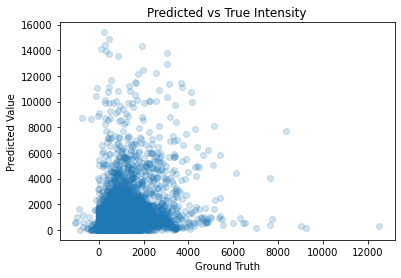

In [50]:
plt.title("Predicted vs True Intensity")
plt.scatter(y_pred, X_test['target_intensity_24h'], alpha=0.2)
plt.ylabel('Predicted Value')
plt.xlabel('Ground Truth')

SHAP Plot below shows us the model focuses mostly on lagged features, month features (correlated with sazonality) and some weather features.

In [57]:
# We now explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test[COLS_TO_KEEP].fillna(9999).astype(float))

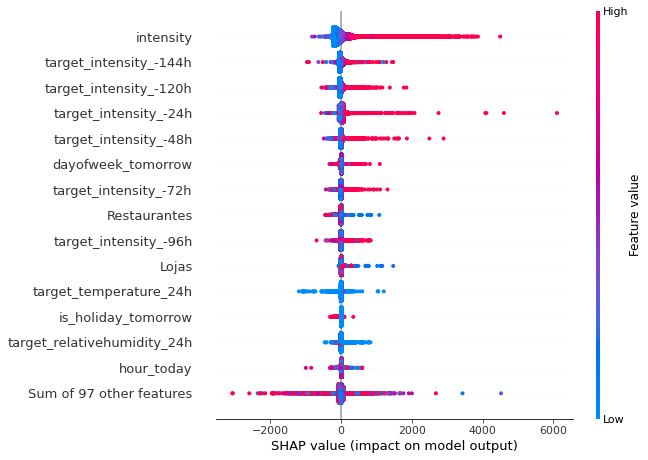

In [58]:
# Let's get a nice plot with the shap values so you can have an intuition on the rationale behind the model learned by the XGBoost Regressor
shap.plots.beeswarm(shap_values, max_display=15)

In [59]:
# TODO: Plot das previsões no mapa
# Tomé e Joana tratam

An example of the model predictions shape and the ground truth:

In [65]:
# We select a sensor
tmp = X_test[X_test.entity_id == 'urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1']

In [66]:
# Select a timepoint
tmp = tmp[
    (tmp.dateobserved < '2020-08-10')# & (tmp.dateobserved > '2018-05-18')
]
tmp

,entity_id,dateobserved,intensity,name,latitude,longitude,entity_type,street,start_date,end_date,...,target_intensity_-120h,target_intensity_-144h,target_intensity_-168h,target_precipitation_24h,target_temperature_24h,target_relativehumidity_24h,target_precipitation_-24h,target_temperature_-24h,target_relativehumidity_-24h,pred_score
1024242,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-09-12 06:00:00,223,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,225.0,240.0,269.0,NaN,NaN,NaN,NaN,NaN,NaN,224.164642
1024341,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-09-12 07:00:00,998,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,469.0,1078.0,996.0,NaN,NaN,NaN,NaN,NaN,NaN,960.630981
1024440,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-09-12 08:00:00,811,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,731.0,1353.0,1290.0,NaN,NaN,NaN,NaN,NaN,NaN,944.857971
1024539,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-09-12 09:00:00,836,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,935.0,1093.0,869.0,NaN,NaN,NaN,NaN,NaN,NaN,998.276917
1024638,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-09-12 10:00:00,895,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,887.0,886.0,967.0,NaN,NaN,NaN,NaN,NaN,NaN,907.832703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277940,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-12-30 19:00:00,876,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,630.0,549.0,924.0,0.0,9.039103,0.937321,0.0,12.290669,0.666467,693.397827
1278022,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-12-30 20:00:00,721,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,500.0,235.0,836.0,0.0,8.098407,0.923500,0.0,11.439031,0.692386,550.928101
1278104,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-12-30 21:00:00,674,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,513.0,157.0,744.0,0.0,7.163013,0.924141,0.0,10.990598,0.708262,515.979370
1278186,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z1,2019-12-30 22:00:00,463,Ponte Infante D. Henrique S-N,41.141767,-8.601803,TrafficFlowObserved,Avenida Gustavo Eiffel,NaN,NaN,...,454.0,188.0,593.0,0.0,6.393223,0.942813,0.0,10.305515,0.725375,339.766693


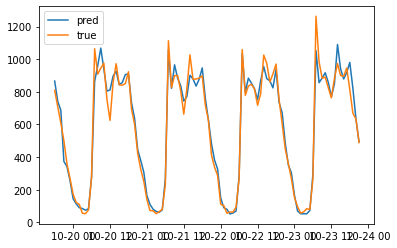

In [67]:
# And we plot the variation of the intensity throughout the day
plt.plot(tmp['dateobserved'][900:1000], tmp['pred_score'][900:1000], label='pred')
plt.plot(tmp['dateobserved'][900:1000], tmp['target_intensity_24h'][900:1000], label='true')
plt.legend()

# TODO: Check if we can make this plot prettier and interactive 

# Conclusions

## What do we propose?

Taking into account our data analysis and the model we trained, we decided that the best way to deploy our model within the city would be through the implementation of smart traffic lights (TIME has a very interesting article on this topic: [https://time.com/5502192/smart-traffic-lights-ai/](https://time.com/5502192/smart-traffic-lights-ai/)). 

### How did we think about this proposal?

We start by showing you some of our preliminary ideas and justifying why they were not suitable for this forecasting model:
 1. We wondered about using this model to optimise travelling routes within the City of Porto. However, we acknowledge that services such as Google Maps, Apple's Maps or Waze do that well.
 2. We thought about framing this problem as an anomaly detection problem with forecasting to predict which regions of the City of Porto could be more likely of car accidents. The main idea was to have a decision support system that could support these regions by increasing vigilance. On the other hand, we recognise that this data analysis and the model that was trained do not focus on anomaly detection. Hence, we refrain from using this idea, due to a lack of evidence between the main goal and all the knowledge we extracted.

Hence, we had to go beyond our horizons and (try to) think outside of the box. 

### How would we do it?

Our smart traffic lights project would be implemented in two phases:
 1. After the installation of smart traffic lights in the City of Porto, we would use our forecasting model to understand which are the zones where we have higher traffic intensities. We would have to manually tune the behaviour of traffic lights in those zones and gather data related to the impact of these manipulations. Intuitively, we would need to gather data daily.
 2. Assuming that Phase 1 had already generated an interesting data set, we could retrain a model which would receive the latitude, longitude, time and if a certain traffic light would be active or not. This way, using this model, we could immediately check the impacts on the traffic intensity in the City of Porto. 
 3. An interesting thing to test: could we generalise this analysis to road signs?

There already some interesting projects/start-ups working on this subject ([https://www.zdnet.com/article/ai-based-traffic-management-gets-green-light/](https://www.zdnet.com/article/ai-based-traffic-management-gets-green-light/)).

Therefore, we interpret this solution as an interesting opportunity for the City of Porto to be sustainable and a pioneer towards smart traffic management.

## How can this traffic-flow forecasting model help us achieve a much more sustainable Porto city?
Following the contextualisation of the WDL team in the challenge document, we start by showing some of the correlations between traffic intensity and the presence of air pollutants:

### TODO: Colocar em forma de Tabela!

We also find it useful to give you some insights about these chemicals to give you intuition on why it is important to keep their concentration in the atmosphere as lower as possible.
 1. NO2: it is one of a group of highly reactive gases known as oxides of nitrogen or nitrogen oxides (NOx). This gas primarily gets in the air from the burning of fuel. For instance, it forms from emissions from cars, trucks and buses, power plants, and off-road equipment. The presence of high concentrations of NO2 in the atmosphere may contribute to several respiratory complications in human beings. Hence, if one lives in a city with high concentrations of NO2, one may be more likely to develop respiratory diseases (particularly, asthma). On the other hand, this presence of NO2 in the atmosphere has also several negative effects on the environment (e.g., NO2 interacts with water, oxygen and other chemicals in the atmosphere to form acid rain, which impacts sensitive ecosystems). Please refer to: [https://www.epa.gov/no2-pollution/basic-information-about-no2#:~:text=Nitrogen%20Dioxide%20(NO2)%20is,from%20the%20burning%20of%20fuel.](https://www.epa.gov/no2-pollution/basic-information-about-no2#:~:text=Nitrogen%20Dioxide%20(NO2)%20is,from%20the%20burning%20of%20fuel.)).
 2. O3: it is a gas composed of three atoms of oxygen and is commonly known as ozone. At a stratospheric level, this gas occurs naturally and is extremely useful in the sense that it forms a protective layer that shields us from the sun's harmful ultraviolet rays. However, at a tropospheric level (i.e., ground level), ozone is created by chemical reactions between oxides of nitrogen and volatile organic compounds (e.g., when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight). Similarly to NO2, ozone is extremely harmful to the respiratory system and may contribute to several other environmental complications (i.e., elevated exposures to ozone can affect sensitive vegetation and ecosystems, including forests, parks, wildlife refuges and wilderness areas). Please refer to: [https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics)).
 3. Ox: TODO (Tiago)
 4. CO: carbon monoxide is also present in the exhaust gases of internal combustion engines and furnaces as a result of the incomplete conversion of carbon or carbon-containing fuels to carbon dioxide. This compound is dangerous to human health since its absorption by red blood cells in preference to oxygen will create a negative impact on the transport of oxygen from the lungs to the tissues, in which it is required. Please refer to: [https://www.britannica.com/science/carbon-monoxide](https://www.britannica.com/science/carbon-monoxide)).
 5. PM1, PM2.5 and PM10: https://www.sciencedirect.com/science/article/abs/pii/S1352231007003299

We now show you example plots to give you the intuition of how traffic intensity contributes to the increase of the concentration of air pollutants in the atmosphere. 

As we explained above, the burning of fossil fuels generates chemical compounds that act as precursors of these pollutants.

Hence, we can see that there is a positive correlation between traffic intensity and the concentration/level of air pollutants in the atmosphere.

Traffic Intensity

![Traffic Intensity](../figures/ct1z6_intensity.png "Traffic Intensity")

NO2 Concentration

![NO2 Concentration](../figures/ct1z6_no2.png "NO2 Concentration")

O3

![O3 Concentration](../figures/ct1z6_o3.png "NO2 Concentration")

Ox

![Ox Concentration](../figures/ct1z6_ox.png "Ox Concentration")

CO

![CO Concentration](../figures/ct1z6_co.png "CO Concentration")

PM1

![PM1](../figures/ct1z6_pm1.png "PM1")

PM2.5

![PM2.5](../figures/ct1z6_pm25.png "PM25")

PM10

![PM10](../figures/ct1z6_pm10.png "PM10")

# Scalability and Impact

The impact of tourism and the economic growth that has taken place in Porto translates into an increase in the number of cars in circulation (source: https://www.dinheirovivo.pt/empresas/porto-tem-mais-carros-por-habitante-do-que-lisboa-12798231.html). Per year, there has been a 6.6% increase in the number of vehicles (i.e., essentially cars) in circulation in the Greater Porto region, and this increase does not seem to be slowing down. 

Let's take the year 2018 as an example. In 2018, the annual average daily traffic was equal to 28,014 vehicles per day, which at the end of the year results in the circulation of approximately 10225 vehicles. Knowing that a typical passenger car emits about 4600 kg of CO2 per year (https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle), there is an increase in CO2 emissions of 47M kg per year!

Considering that at an average speed of 30 mph and 40 mph, CO2 emission is approximately 350 g/mi and 310 g/mi, respectively (source: image deliverable) and that on average, the distance travelled by a Portuguese citizen is 9000 km (source: https://www.publico.pt/2018/01/23/sociedade/noticia/quem-e-o-condutor-portugues-conduz-nove-mil-quilometros-por-ano-tem-carro-com-uma-decada-e-usao-diariamente-1800028), for the same distance travelled, you save ((350 - 310) X (9000 X 0.621371192)) = 223.69 kg CO2 if you increase the speed from 30 mph to 40 mph. 

Thus, the construction of intelligent traffic lights that would turn on and off according to the areas and times of heaviest traffic, would allow the decongestion of traffic in these regions and a greater flow of cars, which would therefore increase their speed and contribute to the reduction of CO2 emissions (https://www.porto.pt/pt/noticia/camara-vai-consumir-energia-100-renovavel-e-evitar-a-emissao-de-165-toneladas-de-co2-por-ano). Hence, this initiative would contribute to making the city of Porto a more sustainable and environmentally friendly city through traffic changes. 

This proposal is well-aligned with the City's strategies towards sustainability and the CO2 levels reduction (see [https://www.porto.pt/pt/noticia/camara-estuda-medidas-para-um-porto-sustentavel-e-mais-amigo-do-ambiente](https://www.porto.pt/pt/noticia/camara-estuda-medidas-para-um-porto-sustentavel-e-mais-amigo-do-ambiente) and [https://www.publico.pt/2020/09/28/local/noticia/novo-pdm-promete-porto-denso-verde-2030-1932911](https://www.publico.pt/2020/09/28/local/noticia/novo-pdm-promete-porto-denso-verde-2030-1932911)).

# TODO: Check source of this image (below).
# TODO: PDF Document of Joana (get some print screens)

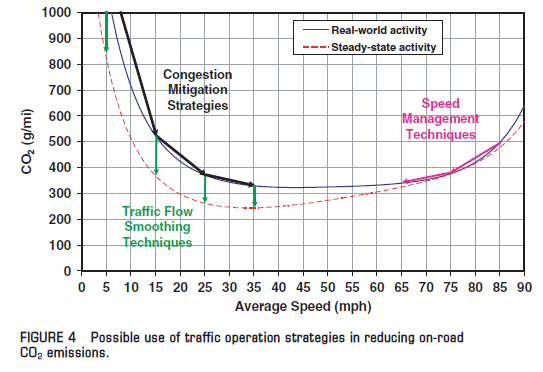

# Ideias:
- Saúde das pessoas (TODO: pesquisar efeito dos outros componentes do air quality), cidade sustentável
- Saúde: rever https://www.universityofcalifornia.edu/news/how-traffic-jams-affect-heart-health


https://en.wikipedia.org/wiki/Smart_traffic_light

# Future Work

Based on our proposal, it would be interesting if we could have access to:
 - data regarding the position of traffic lights;
 - the average speed of cars in that localisation;
 - CO2 levels.

This way, we could analyse the impact of our solution, as well as extract the correlations between the average speed of cars and the air quality.

# TODO: Explain this (above)!